In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score

## Pull CSV Files

In [90]:
zori = pd.read_csv('./data/cleandata/clean_zori.csv').drop('Unnamed: 0', axis = 1)
zhvi = pd.read_csv('./data/cleandata/clean_zhvi.csv').drop('Unnamed: 0', axis = 1)
airq = pd.read_csv('./data/cleandata/clean_airq.csv').drop('Unnamed: 0', axis = 1)
population = pd.read_csv('./data/cleandata/clean_population.csv').drop('Unnamed: 0', axis = 1)
unemployment = pd.read_csv('./data/cleandata/clean_unemployment.csv').drop('Unnamed: 0', axis = 1)
education = pd.read_csv('./data/cleandata/clean_education.csv').drop('Unnamed: 0', axis = 1)
permits = pd.read_csv('./data/cleandata/clean_permits.csv').drop('Unnamed: 0', axis = 1)
IandH = pd.read_csv('./data/cleandata/clean_IandH.csv').drop('Unnamed: 0', axis = 1)
pce = pd.read_csv('./data/cleandata/clean_pce.csv').drop('Unnamed: 0', axis = 1)
vacancy = pd.read_csv('./data/cleandata/clean_vacancy.csv').drop('Unnamed: 0', axis = 1)

In [47]:
IandH.head()

,County,State,Year,Month,Total_Households,Med_income,Year_Month
0,Ada,ID,2014,1,155801.028921,52954.849181,2014_1
1,Ada,ID,2014,2,156168.924513,53370.942329,2014_2
2,Ada,ID,2014,3,156537.688823,53790.304931,2014_3
3,Ada,ID,2014,4,156907.323903,54212.962678,2014_4
4,Ada,ID,2014,5,157277.831808,54638.941462,2014_5


## Intermediate Matrices for Merging Dataframes before Training

In [91]:
one_year_forecast = zori[['Year', 'Month', 'Year_Month']]
one_year_forecast = pd.concat([one_year_forecast, pd.DataFrame(one_year_forecast['Year'].map(lambda year: year - 1))], 
                             axis = 1)
one_year_forecast.columns = ['Year', 'Month', 'Year_Month', 'Year2']
one_year_forecast = pd.concat([one_year_forecast, pd.DataFrame(one_year_forecast['Year'].map(lambda year: year - 2))], 
                             axis = 1)
one_year_forecast.columns = ['Year', 'Month', 'Year_Month', 'Year2', 'Year3']
one_year_forecast['Year_Month2'] = one_year_forecast['Year2'].map(str) + '_' + one_year_forecast['Month'].map(str)
one_year_forecast['Year_Month3'] = one_year_forecast['Year3'].map(str) + '_' + one_year_forecast['Month'].map(str)
one_year_forecast = one_year_forecast[['Year_Month', 'Year_Month2', 'Year_Month3']]
one_year_forecast.drop_duplicates(inplace = True)

In [4]:
one_year_forecast

,Year_Month,Year_Month2,Year_Month3
0,2014_2,2013_2,2012_2
1,2014_3,2013_3,2012_3
2,2014_4,2013_4,2012_4
3,2014_5,2013_5,2012_5
4,2014_6,2013_6,2012_6
...,...,...,...
75,2020_5,2019_5,2018_5
76,2020_6,2019_6,2018_6
77,2020_7,2019_7,2018_7
78,2020_8,2019_8,2018_8


## Final Dataframe for Training

In [92]:
df = zori
df = pd.merge(df, one_year_forecast, on = 'Year_Month')
df = pd.merge(df, zori[['Year_Month', 'ZipCode', 'ZORI']], left_on = ['Year_Month2', 'ZipCode'],
              right_on = ['Year_Month', 'ZipCode'], how = 'left')
df.drop('Year_Month_y', axis = 1, inplace = True)

In [93]:
df = pd.merge(df, zhvi[['Year_Month', 'ZipCode', 'ZHVI']], left_on = ['Year_Month2', 'ZipCode'],
              right_on = ['Year_Month', 'ZipCode'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [94]:
df = pd.merge(df, airq[['County', 'State', 'Year_Month', 'AQI']], left_on = ['County', 'State', 'Year_Month2'],
              right_on = ['County', 'State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [95]:
df = pd.merge(df, population[['County', 'State', 'Year_Month', 'Population']], 
              left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [96]:
df = pd.merge(df, unemployment[['County', 'State', 'Year_Month', 'Unemployment']], 
             left_on = ['County', 'State', 'Year_Month2'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [97]:
df['Year2'] = df['Year'] - 1
df['Year3'] = df['Year'] - 2
df = pd.merge(df, education, left_on = ['County', 'State', 'Year3'], right_on = ['County', 'State', 'Year'], how = 'left')
df.drop('Year_y', axis = 1, inplace = True)

In [98]:
df = pd.merge(df, permits[['State', 'Units', 'Year_Month']], left_on = ['State', 'Year_Month2'], 
              right_on = ['State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [99]:
df = pd.merge(df, IandH[['County', 'State', 'Year_Month', 'Total_Households', 'Med_income']], 
             left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [100]:
df = pd.merge(df, pce[['PCE', 'Year_Month']], left_on = 'Year_Month2', right_on = 'Year_Month')
df.drop('Year_Month', axis = 1, inplace = True)

In [101]:
df = pd.merge(df, vacancy, left_on = ['County', 'State', 'Year3'], right_on = ['County', 'State', 'Year'], how = 'left')
df.drop('Year', axis = 1, inplace = True)

In [102]:
df = df[['Year_x', 'Month', 'ZipCode', 'ZORI_x', 'ZORI_y', 'ZHVI', 'AQI', 'Population', 'Unemployment', 
         'Percent Bachelors', 'Units', 'Total_Households', 'Med_income', 'PCE', 'Rental Vacancy Rate']]

In [103]:
df.columns = ['Year', 'Month', 'ZipCode', 'ZORI', 'ZORI_lagged_1', 'ZHVI_lagged_1', 'AQI_lagged_1', 'Population_lagged_2', 
              'Unemployment_lagged_1', 'Percent Bachelors_lagged_2', 'Permits_lagged_1', 'Total_Households_lagged_2',
              'Med_Income_lagged_2', 'PCE_lagged_1', 'Rental Vacancy Rate_lagged_2']

In [104]:
# Dropping all NaN values instead of imputing for simplicity for now
df = df[(df['Year'] != 2014) & ~((df['Year'] == 2015) & (df['Month'] == 1))]
df = df[~df['Total_Households_lagged_2'].isnull()]
df = df[~df['ZORI'].isnull()]
df = df[~df['ZORI_lagged_1'].isnull()]
df = df[~df['ZHVI_lagged_1'].isnull()]
df = df[~df['AQI_lagged_1'].isnull()]
df = df[~df['Rental Vacancy Rate_lagged_2'].isnull()]
train = df[df['Year'] != 2020]
test = df[df['Year'] == 2020]

In [18]:
pd.options.display.max_columns = None

In [33]:
df.columns

Index(['Year', 'Month', 'ZipCode', 'ZORI', 'ZORI_lagged_1', 'ZHVI_lagged_1',
       'AQI_lagged_1', 'Population_lagged_2', 'Unemployment_lagged_1',
       'Percent Bachelors_lagged_2', 'Permits_lagged_1',
       'Total_Households_lagged_2', 'Med_Income_lagged_2', 'PCE_lagged_1',
       'Rental Vacancy Rate_lagged_2'],
      dtype='object')

In [63]:
df.shape

(162537, 15)

array([[<AxesSubplot:title={'center':'ZORI'}>]], dtype=object)

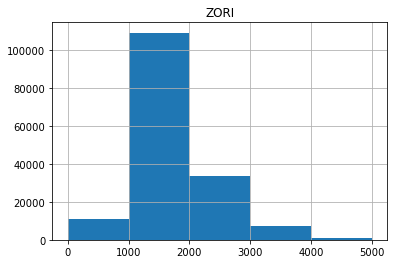

In [66]:
df.hist('ZORI', bins=[0,1000,2000,3000,4000,5000])

In [71]:
df[df['ZORI']>4000].count()

Year                            1700
Month                           1700
ZipCode                         1700
ZORI                            1700
ZORI_lagged_1                   1700
ZHVI_lagged_1                   1700
AQI_lagged_1                    1700
Population_lagged_2             1700
Unemployment_lagged_1           1700
Percent Bachelors_lagged_2      1700
Permits_lagged_1                1700
Total_Households_lagged_2       1700
Med_Income_lagged_2             1700
PCE_lagged_1                    1700
Rental Vacancy Rate_lagged_2    1700
dtype: int64

<AxesSubplot:xlabel='Percent Bachelors_lagged_2', ylabel='ZORI'>

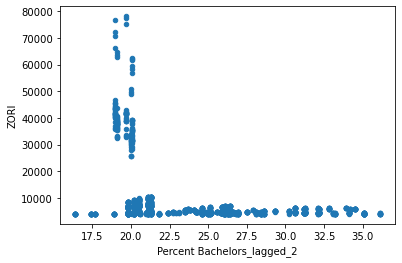

In [69]:
df[df['ZORI']>4000].plot.scatter(x='Percent Bachelors_lagged_2',y='ZORI')

In [89]:
df[df['ZORI']<4000].groupby('ZipCode').count().shape

(2989, 14)

## Multiple Linear Regression on ZORI

In [160]:
regression = LinearRegression()
regression.fit(train.iloc[:, 4:], train.iloc[:, 3])
regression.score(train.iloc[:, 4:], train.iloc[:, 3])

0.9925193482593228

In [161]:
r2_score(test.iloc[:, 3], regression.predict(test.iloc[:, 4:]))

0.9801955421585727

In [162]:
# Regression to see how much prior year ZORI drives current year ZORI
temp = LinearRegression()
temp.fit(np.array(train.iloc[:, 4]).reshape(-1, 1), train.iloc[:, 3])
temp.score(np.array(train.iloc[:, 4]).reshape(-1, 1), train.iloc[:, 3])

0.9915774934484615

In [163]:
r2_score(test.iloc[:, 3], temp.predict(np.array(test.iloc[:, 4]).reshape(-1, 1)))

0.978426063311627

# Multiple Linear Regression on Change in ZORI
# modified to calculate percent rather than absolute change

In [105]:
df_change = df[df['ZORI']<4000].copy()
df_change['Year_Month'] = df_change['Year'].map(str) + '_' + df_change['Month'].map(str)
df_change = pd.merge(df_change, one_year_forecast, on = 'Year_Month')
df_change = pd.merge(df_change, df_change, left_on = ['Year_Month', 'ZipCode'], right_on = ['Year_Month2', 'ZipCode'],
                     how = 'inner')

In [106]:
df_change['ZORI_x'] = 2*(df_change['ZORI_x'] - df_change['ZORI_y'])/(df_change['ZORI_x'] + df_change['ZORI_y'])
df_change['ZHVI_lagged_1_x'] = 2*(df_change['ZHVI_lagged_1_x'] - df_change['ZHVI_lagged_1_y'])/(df_change['ZHVI_lagged_1_x'] + df_change['ZHVI_lagged_1_y'])
df_change['AQI_lagged_1_x'] = 2*(df_change['AQI_lagged_1_x'] - df_change['AQI_lagged_1_y'])/(df_change['AQI_lagged_1_x'] + df_change['AQI_lagged_1_y'])
df_change['Population_lagged_2_x'] = 2*(df_change['Population_lagged_2_x'] - df_change['Population_lagged_2_y'])/(df_change['Population_lagged_2_x'] + df_change['Population_lagged_2_y'])
df_change['Unemployment_lagged_1_x'] = 2*(df_change['Unemployment_lagged_1_x'] - df_change['Unemployment_lagged_1_y'])/(df_change['Unemployment_lagged_1_x'] + df_change['Unemployment_lagged_1_y'])
df_change['Percent Bacehlors_lagged_2_x'] = 2*(df_change['Percent Bachelors_lagged_2_x'] -\
                                            df_change['Percent Bachelors_lagged_2_y'])/(df_change['Percent Bachelors_lagged_2_x'] +\
                                            df_change['Percent Bachelors_lagged_2_y'])
df_change['Permits_lagged_1_x'] = 2*(df_change['Permits_lagged_1_x'] - df_change['Permits_lagged_1_y'])/(df_change['Permits_lagged_1_x'] + df_change['Permits_lagged_1_y'])
df_change['Total_Households_lagged_2_x'] = 2*(df_change['Total_Households_lagged_2_x'] -\
                                           df_change['Total_Households_lagged_2_y'])/(df_change['Total_Households_lagged_2_x'] +\
                                           df_change['Total_Households_lagged_2_y'])
df_change['Med_Income_lagged_2_x'] = 2*(df_change['Med_Income_lagged_2_x'] - df_change['Med_Income_lagged_2_y'])/(df_change['Med_Income_lagged_2_x'] + df_change['Med_Income_lagged_2_y'])
df_change['PCE_lagged_1_x'] = 2*(df_change['PCE_lagged_1_x'] - df_change['PCE_lagged_1_y'])/(df_change['PCE_lagged_1_x'] + df_change['PCE_lagged_1_y'])
df_change['Rental Vacancy Rate_lagged_2_x'] = 2*(df_change['Rental Vacancy Rate_lagged_2_x'] -\
                                              df_change['Rental Vacancy Rate_lagged_2_y'])/(df_change['Rental Vacancy Rate_lagged_2_x'] +\
                                              df_change['Rental Vacancy Rate_lagged_2_y'])

In [107]:
df_change = df_change[['Year_x', 'Month_x', 'ZipCode', 'ZORI_x', 'ZHVI_lagged_1_x', 'AQI_lagged_1_x', 
                      'Population_lagged_2_x', 'Unemployment_lagged_1_x', 'Percent Bachelors_lagged_2_x', 
                      'Permits_lagged_1_x', 'Total_Households_lagged_2_x', 'Med_Income_lagged_2_x', 'PCE_lagged_1_x', 
                      'Rental Vacancy Rate_lagged_2_x']]

In [108]:
df_change.columns = ['Year', 'Month', 'ZipCode', 'ZORI_delta', 'ZHVI_lagged_1_delta', 'AQI_lagged_1_delta',
                    'Population_lagged_2_delta', 'Unemployment_lagged_1_delta', 'Percent Bachelors_lagged_2_delta', 
                    'Permits_lagged_1_delta', 'Total_Households_lagged_2_delta', 'Med_Income_lagged_2_delta', 
                    'PCE_lagged_1_delta', 'Rental Vacancy Rate_lagged_2_delta']

In [113]:
df_change = df_change.fillna(0)

In [114]:
df_change.isnull().sum(axis=0)

Year                                  0
Month                                 0
ZipCode                               0
ZORI_delta                            0
ZHVI_lagged_1_delta                   0
AQI_lagged_1_delta                    0
Population_lagged_2_delta             0
Unemployment_lagged_1_delta           0
Percent Bachelors_lagged_2_delta      0
Permits_lagged_1_delta                0
Total_Households_lagged_2_delta       0
Med_Income_lagged_2_delta             0
PCE_lagged_1_delta                    0
Rental Vacancy Rate_lagged_2_delta    0
dtype: int64

<AxesSubplot:xlabel='Year', ylabel='Unemployment_lagged_1_delta'>

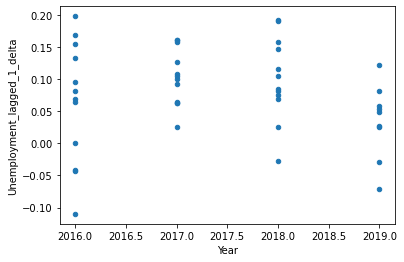

In [119]:
df_change[df_change['ZipCode']==10028].plot.scatter(x='Year',y='Unemployment_lagged_1_delta')

In [125]:
df_change.ZipCode.value_counts().head(50)

90068    45
85301    45
2141     45
92337    45
10457    45
8536     45
20886    45
21014    45
33484    45
33612    45
2909     45
97203    45
89015    45
29650    45
89143    45
46218    45
30034    45
10075    45
32211    45
22102    45
77433    45
2140     45
32909    45
92336    45
74105    45
2460     45
92592    45
92656    45
96818    45
64130    45
80634    45
33613    45
32780    45
55303    45
7960     45
98036    45
75070    45
11743    45
30228    45
32277    45
77375    45
91766    45
85747    45
10014    45
55104    45
32725    45
2138     45
32907    45
2458     45
29205    45
Name: ZipCode, dtype: int64

In [128]:
# fit to individual zip code
r1 = LinearRegression()
y1 = df_change[df_change['ZipCode']==10028]['ZORI_delta']
x1 = df_change[df_change['ZipCode']==10028][['Unemployment_lagged_1_delta','Population_lagged_2_delta','Med_Income_lagged_2_delta','PCE_lagged_1_delta']]
r1.fit(x1, y1)
print(r1.intercept_, r1.coef_, r1.score(x1,y1))

-0.010842667313806842 [-0.03146304  4.91984929 -0.33915798 -0.03942882] 0.9041324099112918


In [129]:
df2 = df[df['ZORI']<4000].copy()

In [130]:
df2.columns

Index(['Year', 'Month', 'ZipCode', 'ZORI', 'ZORI_lagged_1', 'ZHVI_lagged_1',
       'AQI_lagged_1', 'Population_lagged_2', 'Unemployment_lagged_1',
       'Percent Bachelors_lagged_2', 'Permits_lagged_1',
       'Total_Households_lagged_2', 'Med_Income_lagged_2', 'PCE_lagged_1',
       'Rental Vacancy Rate_lagged_2'],
      dtype='object')

In [132]:
# fit to individual zip code of absolute values
r2 = LinearRegression()
y1 = df2[df2['ZipCode']==10028]['ZORI']
x1 = df2[df2['ZipCode']==10028][['Unemployment_lagged_1','Population_lagged_2','Med_Income_lagged_2','PCE_lagged_1']]
r2.fit(x1, y1)
print(r2.intercept_, r2.coef_, r2.score(x1,y1))

-624.8039224197041 [-2.35665919e+01  2.20944500e-03 -6.19741809e-03  9.99417862e+01] 0.6740213434272395


In [123]:
r1 = LinearRegression()
y1 = df_change[df_change['ZipCode']==11422]['ZORI_delta']
x1 = df_change[df_change['ZipCode']==11422][['Unemployment_lagged_1_delta','Population_lagged_2_delta','Med_Income_lagged_2_delta','PCE_lagged_1_delta']]
r1.fit(x1, y1)
print(r1.intercept_, r1.coef_, r1.score(x1,y1))

-0.08751512169302261 [-0.25559551  1.26542802 -4.1540292   0.26806438] 0.714034493809388


In [115]:
#fit to entire set
train_change = df_change[df_change['Year'] != 2019]
test_change = df_change[df_change['Year'] == 2019]

In [116]:
regression_change = LinearRegression()
regression_change.fit(train_change.iloc[:, 4:], train_change.iloc[:, 3])
regression_change.score(train_change.iloc[:, 4:], train_change.iloc[:, 3])

0.1857502234941768

In [228]:
r2_score(test_change.iloc[:, 3], regression.predict(test_change.iloc[:, 4:]))

0.0007700455758817837